Recommender systems are a vital component of the modern Web. Such systems are particularly useful for entertainment products such as movies, music, and TV shows. Many customers will view the same movie, and each customer is likely to view numerous different movies. Customers have proven willing to indicate their level of satisfaction with particular movies, so a huge volume of data is available about which movies appeal to which customers. Companies can analyze this data to recommend movies to particular customers.

### Strategies

Recommender systems are based on one of two strategies. The content filtering approach creates a profile for each user or product to characterize its nature. For example, a movie profile could include attributes regarding its genre, the participating actors, its box office popularity, and so forth. User profiles might include demographic information or answers provided on a suitable questionnaire. The profiles allow programs to associate users with matching products. Content-based strategies require gathering external information that might not be available or easy to collect.

An alternative to content filtering relies only on past user behavior; for example, previous transactions or product ratings without requiring the creation of explicit profiles. This approach is known as collaborative filtering. Collaborative filtering analyzes relationships between users and interdependencies among products to identify new user-item associations.

### Latent factor models

Latent factor models are an alternative approach that tries to explain the ratings by characterizing both items and users on, say, 20 to 100 factors inferred from the ratings patterns. In a sense, such factors comprise a computerized alternative to the aforementioned strategies. For movies, the discovered factors might measure obvious dimensions such as comedy versus drama, amount of action, or orientation to children. For users, each factor measures how much the user likes movies that score high on the corresponding movie factor.

### Matrix factorization methods

Some of the most successful realizations of latent factor models are based on *matrix factorization*. In its basic form, matrix factorization characterizes both items and users by vectors of factors inferred from item rating patterns. High correspondence between item and user factors leads to a recommendation.

### Hierarchichal poisson factorization

One of the simplest matrix factorization method is the *Hierarchical Poisson Factorization* (HPF) developed by David Blei and Prem Gopelen and it's the model implemented in this post. The model assumes that each cell of the observed behavior matrix is drawn from a Poisson distribution whose parameter is a linear combination of the corresponding user preferences and movie attributes. This model have shown [1] to have many desirable properties; like taking into account the sparsity of the rating matrix.

The genrative process of the HPF as describe in the original paper is as follow:

1. For each user $u$:

    a. Sample activity $\xi_u$ $\sim$ Gamma($a'$,$a'/b'$).
    
    b. For each component $k$, sample preference $\theta_{uk}$ $\sim$ Gamma($a$,$\xi_u$).

2. For each movie $v$:

    a. Sample activity $\eta_v$ $\sim$ Gamma($c'$,$c'/d'$).
    
    b. For each component $k$, sample attribute $\beta_{vk}$ $\sim$ Gamma($c$,$\eta_v$).

3. For each user $u$ and movie $v$, sample rating $r_{uv}$ $\sim$ Poisson($\theta_u^T\beta_v$).
 
In this post, we will replace for convenience, the Gamma distribution for *user preference* and *movie attribute* by a Beta distribution.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import theano.tensor as tt
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn
from scipy.linalg import norm

np.random.seed(42)

### Dataset

This dataset is just a tiny subset of a [movielens](http://www.grouplens.org) dataset, published by [GroupLeans research group](http://www.grouplens.org) which was released in the framework of the 2nd International Workshop on Information Heterogeneity and Fusion in Recommender Systems ([HetRec 2011](http://ir.ii.uam.es/hetrec2011 )) and at the 5th ACM Conference on Recommender Systems ([RecSys 2011](http://recsys.acm.org/2011)).

In [2]:
rate = pd.read_csv("data/movies_rate.csv", header=None).values
rate.shape

(100, 6464)

This datset is about 100 users and approximately 6500 movies.

In [3]:
sparsity = 1 - np.count_nonzero(rate)/rate.size
print("The data's sparsity is {:.2f}%".format(100*sparsity))

The data's sparsity is 93.10%


As we can see, the data is very sparse. It means that most of its value is 0.

In [4]:
info = pd.read_csv("data/movies_info.csv")

The `info` dataframe contains some imformations (`title`, `genre`, `year`, `picture`)  about the rated movies, that will be used later in the recommendation process.

### Model building

With PyMC3, it's easy to specify the model and run the inference algorithm.

In [5]:
n_users,n_movies = rate.shape
n_factors = len(info.genre.unique()) # We use the number of `genre` as the number of latent factors

hier_pois_fact = pm.Model()

with hier_pois_fact:
    
    user_act = pm.Gamma("user_act", 10, 2, shape=n_users) # users activity
    user_pref = tt.stack([pm.Beta("user_pref_%d" % k, .5, user_act, shape=n_users) for k in range(n_factors)], axis=1)
    
    movie_pop = pm.Gamma("movie_pop", 15, 5, shape=n_movies) # movies popularity
    movie_attr = tt.stack([pm.Beta("movie_attr_%d" % k, .2, movie_pop, shape=n_movies) for k in range(n_factors)], axis=0)
    
    pm.Poisson("rate", mu=tt.dot(user_pref, movie_attr), observed=rate)

Applied log-transform to user_act and added transformed user_act_log_ to model.
Applied logodds-transform to user_pref_0 and added transformed user_pref_0_logodds_ to model.
Applied logodds-transform to user_pref_1 and added transformed user_pref_1_logodds_ to model.
Applied logodds-transform to user_pref_2 and added transformed user_pref_2_logodds_ to model.
Applied logodds-transform to user_pref_3 and added transformed user_pref_3_logodds_ to model.
Applied logodds-transform to user_pref_4 and added transformed user_pref_4_logodds_ to model.
Applied logodds-transform to user_pref_5 and added transformed user_pref_5_logodds_ to model.
Applied logodds-transform to user_pref_6 and added transformed user_pref_6_logodds_ to model.
Applied logodds-transform to user_pref_7 and added transformed user_pref_7_logodds_ to model.
Applied logodds-transform to user_pref_8 and added transformed user_pref_8_logodds_ to model.
Applied logodds-transform to user_pref_9 and added transformed user_pref_9

### Inference

In [6]:
with hier_pois_fact:
    params = pm.advi(n=10000)

Iteration 0 [0%]: ELBO = -674502.09
Iteration 1000 [10%]: Average ELBO = -624538.3
Iteration 2000 [20%]: Average ELBO = -544153.36
Iteration 3000 [30%]: Average ELBO = -491366.43
Iteration 4000 [40%]: Average ELBO = -457221.13
Iteration 5000 [50%]: Average ELBO = -435034.89
Iteration 6000 [60%]: Average ELBO = -420494.99
Iteration 7000 [70%]: Average ELBO = -410911.49
Iteration 8000 [80%]: Average ELBO = -404376.59
Iteration 9000 [90%]: Average ELBO = -399695.91
Finished [100%]: Average ELBO = -396356.66


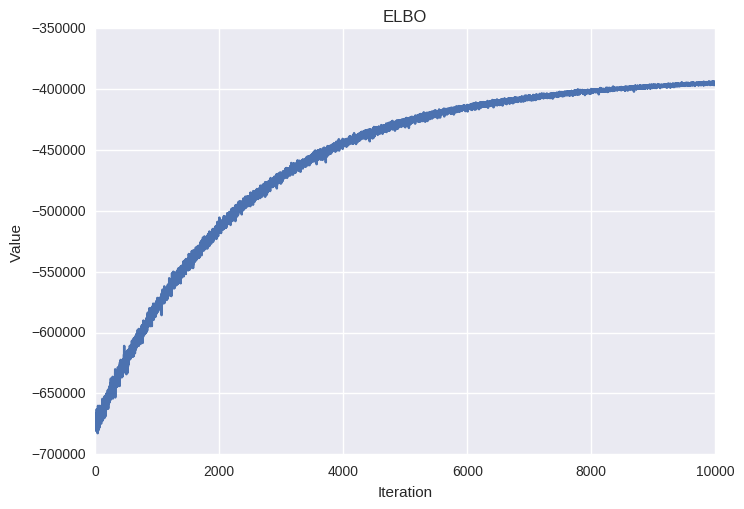

In [7]:
plt.plot(params.elbo_vals)
plt.title("ELBO")
plt.xlabel("Iteration")
plt.ylabel("Value")

In [8]:
with hier_pois_fact:
    trace = pm.sample_vp(params, draws=100)

We can visualize the latent feature for some movies and users to see how they are represented. To do so, we will use a *heatmap* where the rows are the movies and the columns, the latent factors.

In [9]:
movie_attr_mat = np.row_stack([trace["movie_attr_%d" % k][-1] for k in range(n_factors)])
user_pref_mat = np.column_stack([trace["user_pref_%d" % k][-1] for k in range(n_factors)])

### Movies attributes

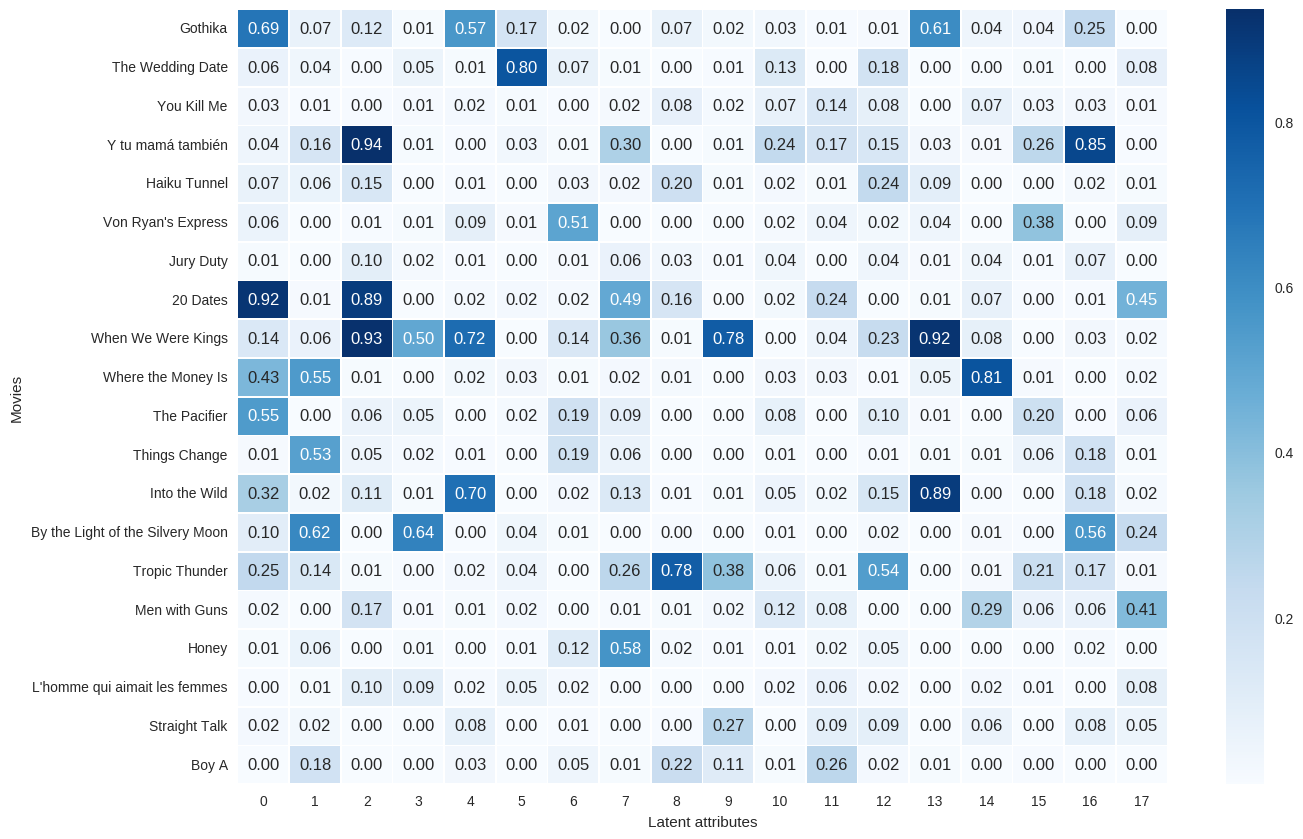

In [10]:
ids = np.random.randint(0, n_movies+1, size=20)
movie_attr_heat = pd.DataFrame(movie_attr_mat.T[ids], index=info.iloc[ids].title)

ax = plt.figure(figsize=(15,10)).add_subplot(111)

ax = seaborn.heatmap(movie_attr_heat, annot=True, fmt=".2f", linewidths=.5, ax=ax, cmap="Blues")
ax.set_ylabel("Movies")
ax.set_xlabel("Latent attributes")

Now that we uncover the movies attibutes, let's see if we can use it to asset the similarity between movies and make recommendation about a choosen one.

### Movies proximity

In an attempt to establish the proximity or closeness between movies in the latent subspace, we will rely on the of the distance between them. One of the simplest distance metric is the [euclidian distance](https://en.wikipedia.org/wiki/Euclidean_distance) and is the one we will use in this post.

The euclidian distance between two vectors $u$ and $v$ is define as follow:

$$d(u,v) = ||u-v||_2$$

After computed, the lower the distance, the closer the vectors or the items representation; 0 meaning that they are identical.

In [11]:
movie_id = np.random.randint(0,n_movies+1)
user_id = np.random.randint(0,n_users+1)

user_movie = np.apply_along_axis(norm, 1, movie_attr_mat.T - user_pref_mat[user_id])
movie_movie = np.apply_along_axis(norm, 1, movie_attr_mat.T - movie_attr_mat[:,movie_id])

These distance vectors correspond to the distance between the latent factors; the lower the closer. We can use these distance vectors to select other movies closer to a given one or movies that a user mike like given his/her rate pattern.

In [12]:
def plot_on(axs, meta, rates=None):
    
    from urllib.request import urlopen
    from urllib.error import URLError, HTTPError
    from PIL import Image
    
    if rates is None:
        xlabel = "Title: {t}\nGenre: {g}\nYear: {y}"
    else:
        xlabel = "Title: {t}\nGenre: {g}\nYear: {y}\nRate: {r}"
    
    for i,ax in enumerate(axs):
        try:
            img = Image.open(urlopen(meta.iloc[i].picture))
            ax.imshow(img)
        except (URLError, HTTPError, ValueError):
            kwargs = dict(horizontalalignment="center", verticalalignment="center")
            fontdict = dict(size=15, weight="bold")
            ax.text(0.5, 0.5, "No Picture", fontdict=fontdict, **kwargs)
        
        t,y,g = meta.iloc[i].title, meta.iloc[i].year, meta.iloc[i].genre
        if rates is None:
            ax.set_xlabel(xlabel.format(t=t,y=y,g=g))
        else:
            r =  rates[i]
            ax.set_xlabel(xlabel.format(t=t,y=y,g=g,r=r))
        
        ax.set_axis_bgcolor("white")
        ax.grid(False)

def rated_by(uid, meta, n=5):
    """
    Show movies rated by a given user.
    """
    
    user = rate[uid]
    movie_ids = np.argsort(user)[::-1][:n]
    rates = user[movie_ids][:n]
    meta = meta.iloc[movie_ids]
    
    title = "Movies rated by user {}".format(uid)
    
    fig,axs = plt.subplots(nrows=1, ncols=n, figsize=(3*n, 4), sharey=True)
    plot_on(axs, meta, rates)
    
    fig.suptitle(title, fontsize=15)

def recommend_to(uid, dist, meta, n=5):
    """
    Show movies recommended to a paticular user, according to the distance vector.
    """
    
    title = "Movies that user {} might like".format(uid)
    
    # discard movies already rated by the user
    rated_idx = rate[uid].nonzero()[0]
    not_rated_idx = np.array([i for i in range(n_movies) if i not in rated_idx])
    idx = np.array([i for i in np.argsort(dist) if i in not_rated_idx])
    
    meta = meta.iloc[idx]
    
    fig,axs = plt.subplots(nrows=1, ncols=n, figsize=(3*n, 4), sharey=True)
    plot_on(axs, meta)
    
    fig.suptitle(title, fontsize=15)

def closer_to(mid, dist, meta, n=5):
    """
    Show movies closer to a given one int the attribute subspace.
    """
    
    t,y = meta.iloc[mid].title, meta.iloc[mid].year
    title = "Movies closer to '{t}, ({y})'".format(t=t, y=y)
    
    idx = np.argsort(dist)[:n]
    meta = meta.iloc[idx]
    
    fig,axs = plt.subplots(nrows=1, ncols=n, figsize=(3*n, 4), sharey=True)
    plot_on(axs, meta)
    
    fig.suptitle(title, fontsize=15)

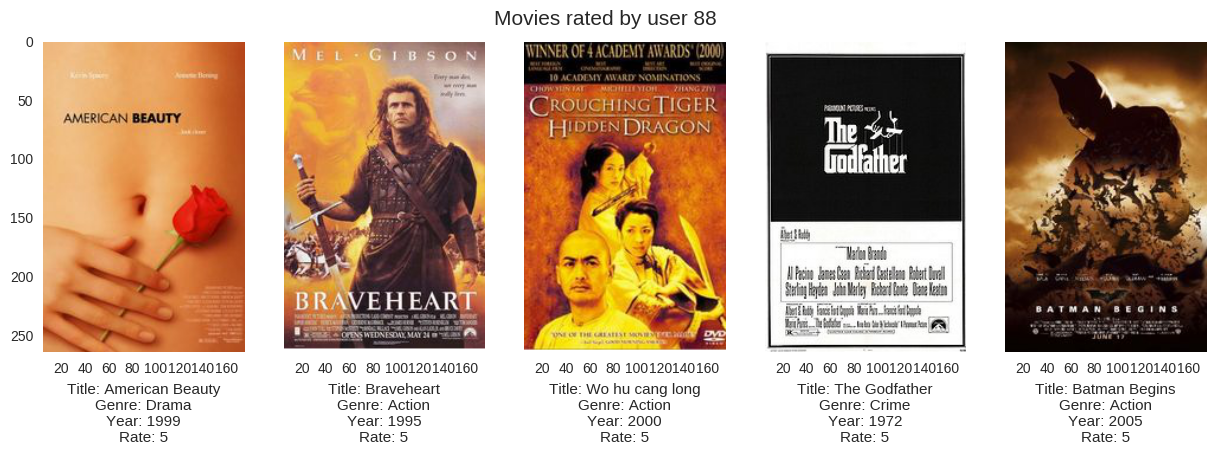

In [13]:
rated_by(user_id, info)

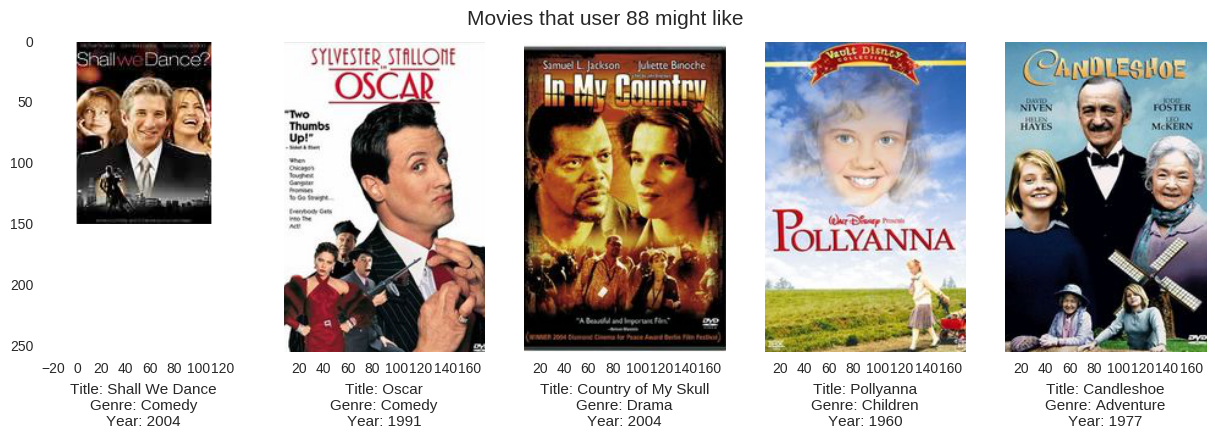

In [14]:
recommend_to(user_id, user_movie, info)

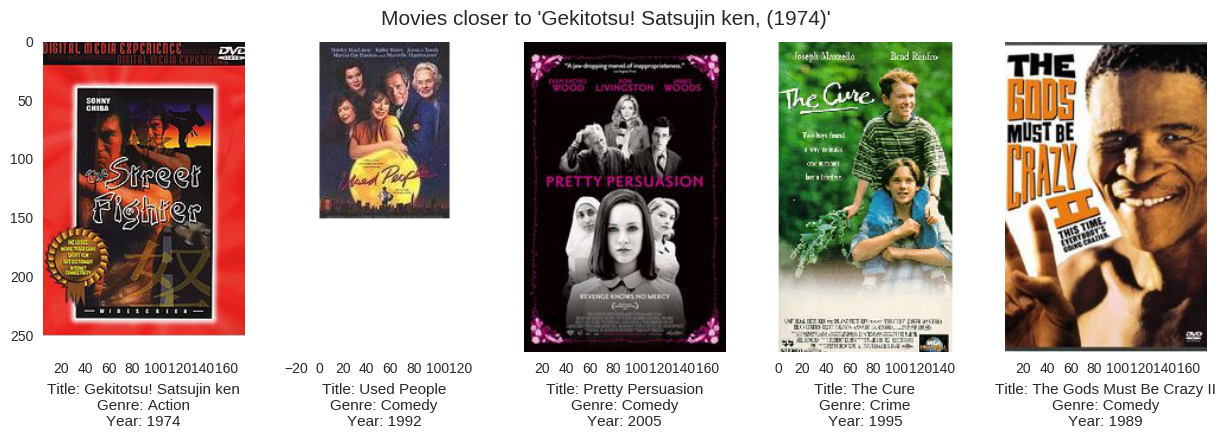

In [15]:
closer_to(movie_id, movie_movie, info)

Is this accurate? One way we can interpret the result it is that the movie in interest, even though is categorize in one genre, shares some features with other movies in different genre. So, may be the heterogeneity observed is just an attempt to highlight these other aspects of the movie. But, we are not movie experts and we haven't watched most of these movies, so we can't confirm if they share something together or not.

### Discussion

In this post, we show a sketch of the implementation of the *Hierarchical Poisson Factorization* (HPF) in PyMC3 and like in any implementation, there are lot of issues open to futher examination.

 - The first of these issues is the choice of the number of latent components. As in most latent variable models and latent factor models, there is no rule of thumb for this choice and some experiments with different numbers are necessary. But in this post, we choosed to stick with the number of *genre* in the dataset. However, it is possible to reduce or augment that number regarding contextual informations.


 - The second of these issues is the choice of the prior distribution and thier parameters. Here, we worked with the *Gamma* distribution for *user activity* and *movie popularity* and the *Beta* distribution for *user preference* and *movie profile*. And futhermore, we set their parameters instead of imposing another distribution on top of them.
 

 - The third of these issues is the choice of the similarity (distance) function. we could experiment with some of them and see the result.
 
The last thing we want to say is that we could implement this model along with other matrix factorization models in orther to compare them and see with one better represent the data. We could also change the inference procedure and use MCMC to see how the results change.

Thank you for following, any comment is welcome.

### Reference

[1] Prem Gopalan, Jake M. Hofman, David M. Blei. Scalable Recommendation with Hierarchical Poisson Factorization. *Computing Research Repository (CoRR), abs/1311.1705*. 2013.